In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('font',**{'family':'sans-serif',
             'sans-serif':['Helvetica', 'HelveticaNeue', 'Helvetica', 'Arial', 'Droid Sans Mono'],
             'style':'normal',
             'size':8})
rc('xtick', labelsize=8)
rc('ytick', labelsize=8)
rc('text', usetex=False) # Must be True to use LaTeX backend
rc("text.latex", preamble="\\usepackage{helvet}\\usepackage{amsmath}")

import string

from datetime import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from operator import sub

import os


from tkinter import Tk
from tkinter.filedialog import askopenfilename, askdirectory

In [2]:
def get_aspect(ax):
    # Total figure size
    fig_width, fig_h = ax.get_figure().get_size_inches()
    
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    
    # Ratio of display units
    display_ratio = (fig_h * h) / (fig_width * w)
    
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return np.abs(display_ratio / data_ratio)

In [3]:
def int_to_roman(input):
    """ Convert an integer to a Roman numeral. """
    ints = (1000, 900,  500, 400, 100,  90, 50,  40, 10,  9,   5,  4,   1)
    nums = ('m',  'cm', 'd', 'cd','c', 'xc','l','xl','x','ix','v','iv','i')
    result = []
    for i in range(len(ints)):
        count = int(input / ints[i])
        result.append(nums[i] * count)
        input -= ints[i] * count
    return ''.join(result)

In [4]:
def create_bar(i, vertical_position, work_package):
    
    work_package_start.append(df.Start[i])
    work_package_end.append(df.End[i])
    work_package_duration.append(df.End[i] - df.Start[i])
    work_package_midpoint.append(df.Start[i] + ((df.End[i] - df.Start[i]) / 2))
    bar_vertical_positions.append(vertical_position)
    
    if df.Annotation.isna()[i]: # If annotation is empty
        work_package_annotations.append(int_to_roman(work_package))
    else: # an annotation has been specified
        work_package_annotations.append(int_to_roman(work_package) + r': ' + df.Annotation[i])
        
    if df.Color[i] in ColorScheme:
        bar_color.append(ColorScheme[str(df.Color[i])])
    else: # use grey as color
        bar_color.append('#7f7f7f')
    
    return

In [5]:
if 'spreadsheet_path' not in dir():
    # withdraw tkinter root window
    root = Tk()
    root.attributes("-topmost", True) # raise to be in front of other windows
    root.withdraw()

    # open dialog box and return the path to the selected file
    spreadsheet_path = askopenfilename(initialdir = os.getcwd(),
                                         title = "Select spreadsheet containing Gantt data",
                                         filetypes = (("Spreadsheets","*.xlsx"),("all files","*.*"))) 

print('spreadsheet_path:')
print(spreadsheet_path)

spreadsheet_path:
C:/Users/Alaric Taylor-Roffey/Documents/GitHub/PyG/Gantt.xlsx


ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

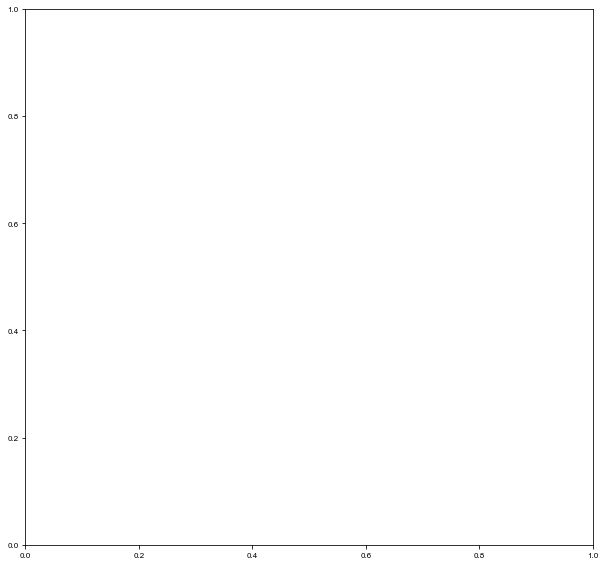

In [15]:
plt.close('all')

fig, ax  = plt.subplots(figsize=(11.7,8.27))    # A4 is 11.7 x 8.27 inches
                                                #      (29.7 x 21.0 cm)
                                                # A3 is 16.5 x 11.7 inches
                                                #      (42.0 x 29.7 cm)

# Setting margins for printing and space for labels on left edge
plt.subplots_adjust(left=0.7/29.7, # fraction of total figsize (A4 is 29.7 x 21 cm)
                    right= 20.7/29.7,
                    top=20.3/21,
                    bottom=1.4/21)

# Alphabet list for labelling work packages
alphabet_list = string.ascii_uppercase

# Dictionary of colours referenced by EXCEL spreadsheet
ColorScheme = {'A': '#957DAD',
               'B': '#E0BBE4',
               'C': '#D291BC',
               'D': '#FEC8D8',
               'E': '#FFDFD3',
               'F': '#90C978',
               'G': '#83C6DD',
               'H': '#AFD5AA',
               'I': '#5DB1D1'}

# Read EXCEL spreadsheet
df = pd.read_excel(spreadsheet_path)


In [ ]:
########################
# HIERACHY (terminology)
#   
# Group
#   Activity
#       Work package
#

# Local variables used for annotations
group = -1 # Parent grouping (only groups 0+ will be converted to text)
activity = -1 # Enumerated line within each group (only activities 0+ will be converted to text)
activity_alpha = '' # e.g. 'a' (arbritraty until set, below)
activity_reference = '' # # e.g. '2b' (arbritraty until set, below)
work_package = int # Enumerated within each line e.g. 2 (arbritraty until set, below)
work_package_roman = '' # e.g. vi (arbritraty until set, below)
vertical_position = -1 # Vertical position, first line will start at +1 as incrementing

# Lists used for plotting
row_title_positions = []
row_titles = []
group_break_positions = []

work_package_start = []
work_package_end = []
bar_vertical_positions = []
bar_color = []
work_package_duration = []
work_package_midpoint = []
work_package_annotations = []

In [ ]:
for i in range(df.shape[0]): # Scan through all rows of the spreadsheet
    print("Reading line:", i+2, "of",df.shape[0]+1)
    
    ################
    # Sense checking
    
    if not df.Start.isna()[i]: # If start date is specified,
        if df.End.isna()[i]: # but end date is empty,
            print("ERROR")
            print("Line", i+2,"specifies an start date but has no end date")
            raise
    
    if df.Start.isna()[i]: # If start date is empty,
        if not df.End.isna()[i]: # but end date is specified,
            print("ERROR!")
            print("Line", i+2,"specifies an end date but has no start date")
            raise
    
    if df.Start.isna()[i]: # If start date is empty,
        if df.End.isna()[i]: # end date is empty
            if df.LineTitle.isna()[i]: # and no line title is specified,
                print("WARNING")
                print("Line", i+2,"is empty and will not be plotted")
    
    if not df.Start.isna()[i]: # If start date is specified,
        if not df.End.isna()[i]: # end date is specified
            if mdates.date2num(df.End[i])-mdates.date2num(df.Start[i]) < 0:
                print("ERROR")
                print("Line", i+2,": task starts after end date...?!")
                raise
     
    ##############
    # Line parsing           
    
    if df.Start.isna()[i]: # If start date is empty,
        if df.End.isna()[i]: # and end date is empty,
            if not df.LineTitle.isna()[i]: # but a title is specified,
                print("New group") # ...then the line is a new group title
                group += 1 # ...so increment the group number
                vertical_position += 1 # and increment the vertical position (new row/line)
                activity = -1 # Reset the activity counter
                
                row_titles.append(df.LineTitle[i]) # LineTitle will be printed unchanged
                row_title_positions.append(vertical_position) # Note the position
                
                group_break_positions.append(vertical_position)
    
    if not df.Start.isna()[i]: # If start date is specified,
        if not df.End.isna()[i]: # and end date is specified,
            if not df.LineTitle.isna()[i]: # and a title is specified,
                print("New activity (1st work-package)") # Then this is a new activity
                activity += 1 # So, increment the activity counter
                activity_reference = str(group) + alphabet_list[activity]
                vertical_position += 1 # and increment the vertical position (new row/line)
                work_package = 1 # and reset work package counter
                
                if group < 0: # If we have not yet specified a group
                    row_titles.append(df.LineTitle[i]) # LineTitle will be printed unchanged
                else:
                    row_titles.append(r' \textbf{' + activity_reference + ')} ' + df.LineTitle[i].strip()) # add numeric/alpha/roman reference and remove leading and tailing spaces
                row_title_positions.append(vertical_position) # note the position
    
                create_bar(i, vertical_position, work_package)
                
    if not df.Start.isna()[i]: # If start date is specified,
        if not df.End.isna()[i]: # and end date is specified,
            if df.LineTitle.isna()[i]: # but no title is specified,
                print("New work package (same activity)") # Then this is a new work package in the same activity (sub-group)
                work_package += 1 # increment the work package number
                
                create_bar(i, vertical_position, work_package)

In [ ]:
###############################
# Plotting resource allocations
    
if True:
    
    all_resources = []
    for i in range(df.shape[0]):
        if not df.ResourceAllocation.isna()[i]: # If resources are specified
            all_resources.extend(df.ResourceAllocation[i].split(";")) # Add each individual resource as seperate item
    
    for i in range(len(all_resources)):
        all_resources[i] = all_resources[i].strip() # Remove leading and trailing spaces
    unique_resources = list(set(all_resources))
    unique_resources.remove('') # Remove blank items
    unique_resources.sort() # Alphabetical sort
    unique_resources.reverse() # Reverse order (as plotting in this order, from Z up to A)
    
    
    resource_position = -1 # Initiate counting from -1 (as )
    for resource in unique_resources:
        print('Collating resource: ', resource)
        for i in range(df.shape[0]): # Iterate through all lines of spreadsheet
            if type(df.ResourceAllocation[i]) == str:
                if resource in df.ResourceAllocation[i].split(";"):
                    print(resource, "found on line", i+2, "of", df.shape[0]+1)
                    if not df.Start.isna()[i]: # If start date is specified,
                        if not df.End.isna()[i]: # and end date is specified,
                            if mdates.date2num(df.End[i])-mdates.date2num(df.Start[i]) > 0: # and start and end are in the correct order
                                ax.barh(y = resource_position,
                                        width = mdates.date2num(df.End[i]) - mdates.date2num(df.Start[i]),
                                        left = mdates.date2num(df.Start[i]),
                                        height = 0.9,
                                        align='center',
                                        color = '#000000',
                                        alpha=0.3)
                            else:
                                print("Error: Dates incorrectly specified (ends before start)")
                        else:
                            print("Error: Start date has been specified, but end date has not")
        row_title_positions.append(resource_position)
        row_titles.append(resource)
        resource_position -= 1 # iterate in reverse
    
    # Add title for resources chunk
    row_title_positions.append(resource_position)
    row_titles.append(r'\textbf{Key resources allocations}')
    
    # Divider between resources and work packets
    ax.axhline(y = 0,
               linestyle = '-',
               color = '#000000',
               alpha = 1.0,
               linewidth = 0.75)

In [ ]:
ax.set_yticks(row_title_positions)
ax.set_yticklabels(row_titles)

ax.tick_params("y", left=False, labelleft=False)
ax.tick_params("y", right=True, labelright=True)

ax.grid(b = True,
        which = 'major',
        axis = 'x',
        linestyle = ':',
        color = 'tab:gray',
        alpha = 0.5,
        linewidth = 0.75)

ax.grid(b = True,
        which = 'minor',
        axis = 'x',
        linestyle = ':',
        color = 'tab:gray',
        alpha = 0.2,
        linewidth = 0.75)
                            
# Plot bars
ax.barh(y = bar_vertical_positions,
        width =mdates.date2num(work_package_end) - mdates.date2num(work_package_start),
        left = mdates.date2num(work_package_start),
        height = 0.9,
        align='center',
        color = bar_color)

# Annotate each bar
for i in range(len(work_package_start)):
    if type(work_package_annotations[i]) == str:
        ax.annotate(s = work_package_annotations[i],
                    xy = (mdates.date2num(work_package_midpoint[i]), bar_vertical_positions[i]),
                    xycoords = 'data',
                    horizontalalignment='center',
                    verticalalignment='center')

for division_position in group_break_positions:
    print("Group divider placed at:", division_position)
    # Plot dashed lines between each group
    ax.axhline(y = division_position,
               linestyle = ':',
               color = 'tab:gray',
               alpha = 0.5,
               linewidth = 0.75)

#plt.title('')
#plt.xlabel('')
#plt.ylabel('')

#plt.tight_layout()



plt.xlim(left = np.min(work_package_start))
plt.xlim(right = np.max(work_package_end))
plt.ylim(bottom = np.min(row_title_positions))
plt.ylim(top =np.max(row_title_positions) + 0.75)

ax.invert_yaxis()  # labels read top-to-bottom

# format xaxis with 3 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=3))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b \n %Y"))

ax.get_xaxis().set_minor_locator(mdates.MonthLocator(interval=1))
#ax.get_xaxis().set_minor_formatter(mdates.DateFormatter("%b %Y"))

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
ax.xaxis_date()


## recompute the ax.dataLim
#ax.relim()
## update ax.viewLim using the new dataLim
#ax.autoscale_view(tight=True)

plt.show()     

In [ ]:
# Toggle save (takes time)
if True:
    fig.savefig('Gantt.png', dpi=300)
    fig.savefig('Gantt.pdf')
    plt.close('all')
    os.remove('Gantt.xlsx')